In [17]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings(action='ignore')  

In [18]:
# reading the dataset
path    = "./dataset/data.csv"

profiles_df = pd.read_csv(path)


In [19]:
#getting an overview of the data
profiles_df.head()

,Company,Profile,Technologies,Diploma,Experience,City
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


In [20]:
#priting some summary stats about the data
profiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Company       9565 non-null   object
 1   Profile       9563 non-null   object
 2   Technologies  9582 non-null   object
 3   Diploma       9582 non-null   object
 4   Experience    9488 non-null   object
 5   City          9582 non-null   object
dtypes: object(6)
memory usage: 449.3+ KB


Observations made so far:
* Variable experience is a string, but it's supposed to be an integer. Moreover, some float values are expressed with "," but they are supposed to be with "."
* We have some missing values in the columns Experience, Company, Profile 

In [21]:
# format properly the wrong typed floats
profiles_df['Experience'] = profiles_df['Experience'].\
    apply(lambda x: float(x.replace(',','.')) if ',' in str(x) else float(x))

# checking the results
profiles_df.dtypes


Company          object
Profile          object
Technologies     object
Diploma          object
Experience      float64
City             object
dtype: object

**1 -a) How many observations in the dataset?**

In [22]:
print(f" This dataset has {profiles_df.shape[0]} observations")


 This dataset has 9582 observations


**1 -b )Are there missing values ?**

In [23]:
profiles_df.isna().sum(axis=0)[profiles_df.isna().sum(axis=0) !=0]

Company       17
Profile       19
Experience    94
dtype: int64

**Yes,** the columns **"Entreprise", "Metier" et "Experience"** have missing values

**2) Imputation of missing values for the  "Experience" variable for each profile type :**                          


In [24]:
profiles_df_exp_na =  profiles_df['Experience'].isna() #mask for na values in the profile column
profiles_df.iloc[profiles_df['Experience'][profiles_df_exp_na].index]['Profile'].value_counts()

Profile
Data scientist         32
Data architecte        23
Data engineer          20
Lead data scientist    19
Name: count, dtype: int64

**2 -a) Impute missing values by median value for data scientists**

In [25]:
ds_median_exp = profiles_df.loc[(profiles_df["Profile"]=="Data scientist") ,"Experience"].mean()
profiles_df.loc[(profiles_df["Profile"]=="Data scientist") 
                & (profiles_df['Experience'].isna()),"Experience"] = ds_median_exp

**2 -b)  Impute missing values by median value for data engineer**

In [26]:
de_mean_exp = profiles_df.loc[(profiles_df["Profile"]=="Data engineer") ,"Experience"].mean()
profiles_df.loc[(profiles_df["Profile"]=="Data engineer") 
                & (profiles_df['Experience'].isna()),"Experience"] = de_mean_exp

**2 -c)  Impute missing values by mean value for Lead Data scientist**

In [27]:
lds_mean_exp = profiles_df.loc[(profiles_df["Profile"]=="Lead data scientist") ,"Experience"].mean()
profiles_df.loc[(profiles_df["Profile"]=="Lead data scientist") 
                & (profiles_df['Experience'].isna()),"Experience"] = lds_mean_exp

**2 -d)  Impute missing values by mean value for Data arhcitecte**

In [28]:
da_mean_exp = profiles_df.loc[(profiles_df["Profile"]=="Data architecte") ,"Experience"].mean()
profiles_df.loc[(profiles_df["Profile"]=="Data architecte") 
                & (profiles_df['Experience'].isna()),"Experience"] = da_mean_exp

In [29]:
#Checking the results
profiles_df.iloc[profiles_df['Experience'][profiles_df['Experience'].isna()].index]['Profile'].value_counts()


Series([], Name: count, dtype: int64)

**3) What's the average years of experience for each profile ?**

In [30]:
# Calcul de la moyenne des années d'expérience pour chaque profil sélectionné
experiences = dict(profiles_df[['Profile', "Experience"]].groupby("Profile").mean()['Experience'])

# Affichage de la moyenne des années d'expérience pour chaque profil
for profile in experiences:
    print(f"The {profile} has an average {experiences[profile]:.2f} years of  experience")


The Data architecte has an average 3.00 years of  experience
The Data engineer has an average 2.98 years of  experience
The Data scientist has an average 2.24 years of  experience
The Lead data scientist has an average 3.97 years of  experience


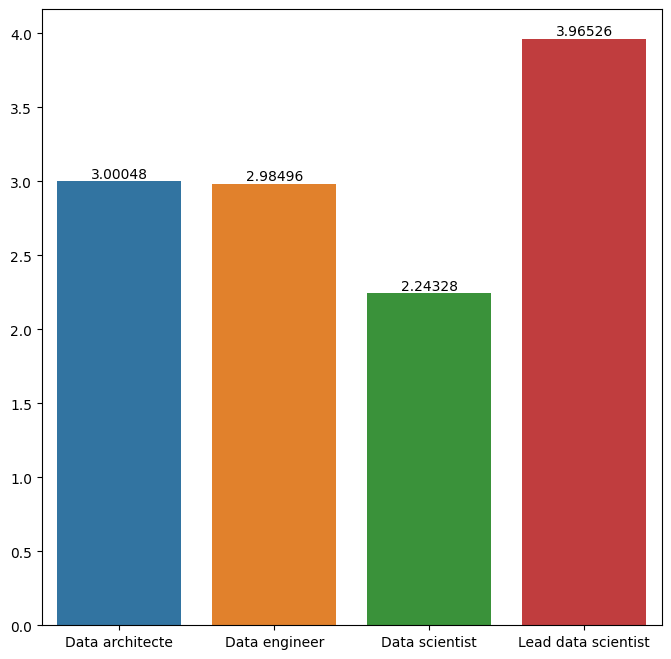

In [31]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(x=list(experiences.keys()), y=list(experiences.values()),palette="tab10") 
for i in ax.containers:
    ax.bar_label(i);

**6) WHat's the top 5 most represented Technologies among profiles ?**

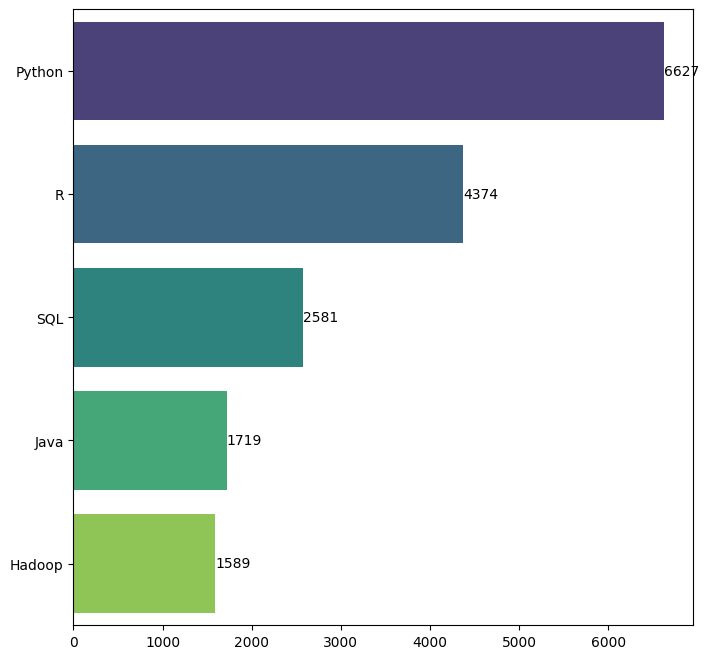

In [32]:
top_tech = dict(
    profiles_df["Technologies"]
    .str.split('/', expand=True)
    .stack()
    .value_counts()
    .sort_values(ascending=False)[:5]
)
plt.figure(figsize=(8, 8))
ax = sns.barplot(y=list(top_tech.keys()), x=list(top_tech.values()),palette='viridis')
for i in ax.containers:
    ax.bar_label(i);


7-1) Feature engineering and processing
We will try to create some new features to enrich our dataset.Those features are:
* pluridisciplinarity: This new feature try to take into condiseration the number of technologies a candidate master, or present in his resumé
* top 10 skills: This new feature checks counts the number of skills that are among the top 10 skills required for his role.
**Note:** Since we have 4 distincts profiles we will create 4 new columns.

In [ ]:
top10skills_ds = ["python","sql","r","mysql","scikit-learn","tensorflow","deep learning","machine learning","powerbi"]
top10skills_de = ["python","sql","python","hadoop","aws","azure","gcp"]
top10skills_da = ["python","c","azure","java","hadoop","aws","gcp","oracle",""]

In [ ]:
profiles_df['pluridisciplinarity'] = profiles_df["Technologies"].apply(lambda s:len(s.split("/")))


7-2) Feature encoding
We are meanly focused on encoding important string variables like Technologies,Diploma.
* Diploma: This variable has 4 values Master, PhD, Bachelor, No diploma.
We will encode them, in as ordinal variables with from 3 to 0 (PhD to No diploma).
The idea here is that for most of the profiles, having a degree increases your chances to get it.



In [60]:
diploma_to_encoding = {
    "Phd":3,
    "Master":2,
    "Bachelor":1,
    "No diploma":0
}
profiles_df['diploma_encoding'] = profiles_df['Diploma'].apply(lambda diploma:diploma_to_encoding[diploma] )

In [57]:
profiles_df.Diploma.value_counts()

Diploma
Master        4971
Phd           2258
Bachelor      1392
No diploma     961
Name: count, dtype: int64

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit_transform('poooo'.split('/')).toarray()

array([[1.]])

**7) Réaliser une méthode de clustering non supervisée de votre choix pour faire
apparaître le nombre de clusters que vous jugerez pertinents. Donnez les
caractéristiques de chacun des clusters.              
a) Justifier le nombre de clusters**


Parmi les méthodes de clusterings, qui existent nous avons choisi d'implemter la méthode **KMEANS** car:

- facile à implémenter et interpréter 
- Peut gérer les données de haute dimension


Avant de passer à la modélisation, il est important de préparer les données.
Il s'agira en autre de :

- Encoder les valeurs non-numériques (Technologies, Diplome) avec Label Encoder (Approche N°1) Puis One Hot Encoder (Approche N°2)</li>
-  Supprimer les colonnes non pertinentes
-  Normaliser les données (avec standardscaler)
-  Choisir le nombre de cluster (Méthode du coude) 
-  Entrainer et tester le modèle avec le nombre choisi précédemment 


Nous utilisons la méthode du coude (Elbow Method en anglais), afin de déterminer le nombre de cluster.   
En effet, elle est très simple et permet de trouver de façon intituitive (graphique) le nombre approprié de clusters

**Approche N°1**

La BD a les caractéristiques suivantes : (9582, 3)


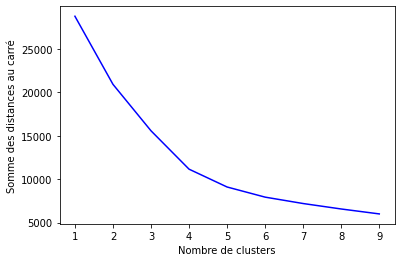

In [73]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Créer l'objet LabelEncoder
labelencoder = LabelEncoder()

# Encoder la variable diplome
diplomes = labelencoder.fit_transform(candidats_imputer['Diplome'])

# Encoder la variable technologies
technologies = labelencoder.fit_transform(candidats_imputer['Technologies'])

# Créer une copie de la BD
data = candidats_imputer.copy()

# Création des nouvelles variables résultant de ces encodages
data['diplomes_enc'] = diplomes
data['technologies_enc'] = technologies


# Sélectionner les colonnes d'intérêt
variables = ['diplomes_enc','technologies_enc', 'Experience']
data = data[variables]



# Mettre tous les features dans la même échelle
X = StandardScaler().fit_transform(data)

print(f"La BD a les caractéristiques suivantes : {X.shape}")
# Méthode du coude
sum_of_square_distance = {}

# Tester plusieurs valeurs de clusters
for k in range(1, 10):
    # Entraîner l'algorithme KMeans pour cette valeur de k
    # Random_state pour la reproductibilité du code
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=k).fit(X)
    sum_of_square_distance[k] = kmeans.inertia_

# Afficher la courbe du nombre de clusters en fonction de la somme des distances au carré
plt.plot(list(sum_of_square_distance.keys()), list(sum_of_square_distance.values()), color="b")
plt.xlabel("Nombre de clusters")
plt.ylabel("Somme des distances au carré")
plt.show()

D'après le graphique précédent, nous choissons la valeur **4** comme nombre de cluster, car après 4 la  la somme des distance au carré ne diminue plus de façon significative.Ce qui correspond à la valeur attendue (car la BD contient 4 types de profiles)

In [74]:
kmeans_l = KMeans(n_clusters=4, max_iter=1000,random_state=4).fit(X)
silhouette_l = silhouette_score(X, labels=kmeans_l.labels_)
ssd = kmeans_l.inertia_

print(f"Le score de silhouette = {silhouette_l}")
print(f"The SSD = {ssd:.2f}")


Le score de silhouette = 0.3732462447155676
The SSD = 11151.43


**Approche N°2**

La BD a les caractéristiques suivantes : (9582, 62)


<Figure size 1600x1600 with 0 Axes>

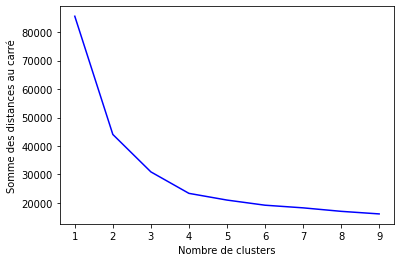

In [75]:
# Encoder les variables de type str(object) grâce au One Hot Encoding
data_one_hot = candidats_imputer.copy()
diplomes_one = data_one_hot["Diplome"].str.get_dummies()
technologies_one = data_one_hot["Technologies"].str.get_dummies()


#concater les résultats et obtention de la BD de train
data_one_hot = pd.concat([data_one_hot['Experience'], diplomes_one, technologies_one], axis=1)

print(f"La BD a les caractéristiques suivantes : {data_one_hot.shape}")

sum_of_square_distance = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=k).fit(data_one_hot)
    sum_of_square_distance[k] = kmeans.inertia_

plt.figure(figsize=(8, 8), dpi=200)
fig, ax = plt.subplots()
ax.plot(list(sum_of_square_distance.keys()), list(sum_of_square_distance.values()), color="b")
ax.set_xlabel("Nombre de clusters")
ax.set_ylabel("Somme des distances au carré")
plt.show()


De même, d'après le graphique précédent, nous choissons la valeur <b>4</b> comme nombre de cluster, car après 4 la  la somme des distance au carré ne diminue plus de façon significative. Ce qui correspond à la valeur attendue (car la BD contient 4 types de profiles)

In [76]:
kmeans_one = KMeans(n_clusters=4,max_iter=1000,random_state=4).fit(data_one_hot)
print(f"Le silhouette score  =  {silhouette_score(data_one_hot,labels=kmeans_one.labels_)}")
print(f"The SSD =  {kmeans_one.inertia_}")

Le silhouette score  =  0.28822875139282567
The SSD =  23347.526401192


**b. Justifier la performance de votre algorithme grâce à une métrique.**

Le tableau ci-dessous, résume les deux approches nous avons utilisés
\begin{array}{|c|c|c|c|}
\hline
\text{Methods} & \text{Silhouette Score} & \text{Somme des distances au carré} \\
\hline
\text{ONE Hot} & \text{0.2882} & \text{ 23,347.5264}  \\
\text{Label Encoder} & \textbf{\text{0.3733}} & \textbf{\text{ 11,129.77}}  \\
\hline
\end{array}



La méthode One Hot crée  15 fois plus  variables supplémentaires  par rapport à la méthode LabelEncoder. En analysant les métriques calculées, on observe que la méthode LabelEncoder présente le meilleur score de silhouette et la somme la plus faible des carrés des distances par rapport aux centres des clusters. La valeur élevée de la somme des distances au carré en One hot peut s'expliquer par la haute dimensionalité (62) variables introduite par la méthode.

**7-c ) Interpréter votre résultat.**

Conclusion :
On peut conclure que l'algorithme K-Means a réalisé un travail satisfaisant en identifiant les 4 clusters (profils de Métiers) présents dans le jeu de données. Ce résultat est caractérisé par un coefficient de silhouette de **0.37** pour l'approche N°1, qui bien qu'inférieur à 0.5, reste néanmoins acceptable car il est supérieur à 0. Une valeur inférieure à cela indiquerait une capacité limitée du modèle à associer chaque point à un cluster de manière significative.

**8) Réaliser la prédiction des métiers manquants dans la base de données par
l'algorithme de votre choix  
a. Justifier la performance de votre algorithme grâce à une métrique.**

In [77]:
def encodage_variable(data_to_encode, columns_to_encode, encoder=labelencoder):
    """
    Encode les variables spécifiées dans un jeu de données.
    """
    # Créer une copie de la base de données
    data = data_to_encode.copy()

    # Encoder les variables
    for column in columns_to_encode:
        # Encoder la variable spécifiée
        result = encoder.fit_transform(data_to_encode[column])
        data[column + '_enc'] = result

    return data


In [78]:
#preparation des données
#séparation des candidats avec métiers et ceux sans
candidats_sans_metier = candidats_imputer[candidats_imputer.Metier.isna()]
candidats_avec_metier = candidats_imputer[~candidats_imputer.Metier.isna()]


# Créer l'objet LabelEncoder
labelencoder = LabelEncoder()
#encodage des variables
candidats_avec_metier = encodage_variable(candidats_avec_metier,['Technologies','Diplome'])
candidats_sans_metier = encodage_variable(candidats_sans_metier,['Technologies','Diplome'])

#separation des variables et labels
Y = candidats_avec_metier['Metier']
X = candidats_avec_metier[['Technologies_enc','Diplome_enc','Experience']]

# Mettre tous les features dans la même échelle
X = StandardScaler().fit_transform(X)

#division de la BD en train et test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X,Y,test_size=0.3,random_state=101)

L'idée ici par la suite serait de tester plusieurs modèles de classification avec les paramètres par défaut,
les comparer selon l'accuracy de train et choisir le meilleur que nous pourrons optimiser en changeant les hyper paramètres

Nous nous interressons aux SVC, Decision Tree et KNN

In [79]:
# Importations 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Dictionnaire de modèles
models = {'svc': SVC, "knn": KNeighborsClassifier, "dtree": DecisionTreeClassifier}
models_objects = {}  # Contiendra les modèles (objets)
accuracy_models = {}

# Boucle pour entraîner et stocker les modèles, leurs accuracy
for model_name, model_class in models.items():
    clf = model_class()
    clf.fit(X_train, y_train) 
    models_objects[model_name] = clf
    accuracy_models[model_name] = clf.score(X_train, y_train)

# Affichage des précisions des modèles
for model, accuracy in accuracy_models.items():
    print(f"L'accuracy de train du modèle {model} est {accuracy}")


L'accuracy de train du modèle svc est 0.5170301762772632
L'accuracy de train du modèle knn est 0.8078876605915746
L'accuracy de train du modèle dtree est 0.9262025694651927


In [80]:
from sklearn.metrics import accuracy_score, classification_report
print(f"L'accuracy test est {accuracy_score(y_test,models_objects['dtree'].predict(X_test))}")
print(classification_report(y_test,models_objects["dtree"].predict(X_test)))

L'accuracy test est 0.8769606134541652
                     precision    recall  f1-score   support

    Data architecte       0.99      0.97      0.98       645
      Data engineer       1.00      1.00      1.00       671
     Data scientist       0.83      0.88      0.86      1171
Lead data scientist       0.58      0.48      0.53       382

           accuracy                           0.88      2869
          macro avg       0.85      0.83      0.84      2869
       weighted avg       0.87      0.88      0.87      2869



In [81]:
#pourcetage de métier dans la base de donnés
Y.value_counts() / Y.shape

Data scientist         0.404162
Data engineer          0.245425
Data architecte        0.222001
Lead data scientist    0.128412
Name: Metier, dtype: float64

À partir de l'analyse du rapport de classification, on constate que les métriques de précision, de rappel et de F1-score sont excellentes pour les classes Data architecte, Data engineer et Data scientist, atteignant même parfois les 100%. Cependant, les performances obtenues pour la classe Lead Data scientist sont relativement faibles. Cela pourrait être dû au fait que cette catégorie n'est pas suffisamment représentée dans la base de données, ne comptant que pour environ 13% de l'échantillon. (confère la cellule précédente)

In [82]:
#prediction des metiers manquants
#separation des variables et labels

X_manquant = candidats_sans_metier[['Technologies_enc','Diplome_enc','Experience']]

# Mettre tous les features dans la même échelle
X_manquant = StandardScaler().fit_transform(X_manquant)
candidats_sans_metier["Prediction_Metier"] = models_objects['dtree'].predict(X_manquant) #models_objects['dtree'] contient le model de dtree entrainé précédement
candidats_sans_metier

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Technologies_enc,Diplome_enc,Prediction_Metier
346,Jacobs,NaN,Python/Spark/GNU/Linux,No diploma,2.5,Paris,confirmé,9,2,Data scientist
2058,Ball Aerospace,NaN,VBA/Python/Excel/R,Master,15.0,Lyon,expert,13,1,Data scientist
2670,"eHire, LLC",NaN,Java/C/C++/R/Python,Master,1.5,Toulouse,confirmé,3,1,Data architecte
2899,Norfolk Southern Corp,NaN,Python/Tensorflow/scikit-learn/Deep learning/R,Phd,0.0,Grenoble,debutant,10,3,Data scientist
3346,J.E. Ranta Associates,NaN,Cassandra/MongoDB/NoSQL/AWS,Master,7.0,Rennes,avancé,0,1,Data engineer
4248,KPMG,NaN,Python/Microsoft Azure/R/SQL,Phd,2.0,Lyon,confirmé,6,3,Data scientist
4290,"Pandora Media, Inc.",NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Phd,1.5,Toulouse,confirmé,12,3,Data scientist
4292,Partners HealthCare(PHS),NaN,SAS/Teradata/SQL/R/Python/Machine learning/Ang...,Master,8.0,Bordeaux,avancé,12,1,Lead data scientist
5425,Ashton Lane Group,NaN,Python/Pyspark/Spark,No diploma,5.0,Lyon,avancé,7,2,Data architecte
5593,Lighthouse Lab Services,NaN,Python/R/machine learning/Excel/VBA/C++,Master,3.0,Lyon,confirmé,8,1,Data scientist


**8-b) Interpréter votre résultat**  
Parmi les trois algorithmes que nous avons évalués, l'arbre de décision a affiché la meilleure accuracy sur le dataset de train. Toutefois, la précision sur l'ensemble de test est légèrement inférieure à celle du dataset de test.

Néanmoins, lorsqu'on examine les prédictions faites pour les métiers manquants, on observe que le modèle effectue un travail assez satisfaisant. En se basant sur notre expertise, certains éléments de compétences correspondent clairement à celles d'un Data Engineer, et le modèle a correctement étiqueté ce métier :

- Cassandra/MongoDB/NoSQL/AWS
- Map-Reduce/HDFS/PIG/HBASE/Python/Cassandra

Ces compétences ont été convenablement associées au profil de Data Engineer par le modèle, ce qui suggère une capacité adéquate du modèle à identifier des caractéristiques spécifiques aux différents métiers.


Aussi, en se basant sur notre "expertise" par exemples les compétences suivantes correspondent bien  à celle d'un Data scientist et le métier a été correctement labelisé: 

- Python/R/machine learning/Excel/VBA/C++ 
- SAS/Teradata/SQL/R/Python/Machine learning/Ang..
- Python/Tensorflow/scikit-learn/Deep learning/R	


En outre, en se basant sur notre "expertise" par exemples les compétences suivantes correspondent bien  à celle d'un Data architecte et le métier a été correctement labelisé: 

- Linux/Python/Hadoop/Perl/Ruby 

**Merci pour votre temps !!!**